<a href="https://colab.research.google.com/github/chahn85/UNOS_Synthetic/blob/main/Syn_MELD_KM_UNOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install lifelines

In [2]:
# Imports and device setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load data
syn_df = pd.read_csv('/content/drive/MyDrive/SyntheticData/synthetic_data_10M.csv')
test_df = pd.read_csv('/content/drive/MyDrive/SyntheticData/test_processed (2).csv')
val_df = pd.read_csv('/content/drive/MyDrive/SyntheticData/val_processed.csv')
df = pd.concat([test_df, val_df], ignore_index=True)

real_df = df.copy()

# (Optional) Display first few rows
display(real_df)


Using device: cuda


,Age,BMI,Na,Cr,INR,Bili,Albumin,MELD,tte,Gender,ABO,Dialysis,Etiology,Ethnicity,diab_group_labeled,Encephalopathy_Status,Ascites_Status,outcome
0,59.0,29.629630,142.0,0.50,1.50,4.30,3.8,16.0,1000.0,F,A,N,Viral,Hispanic/Latino,No Diabetes,Grade 1-2,Moderate,1
1,68.0,28.289299,127.0,1.41,1.70,11.40,2.5,30.0,7.0,M,O,N,Other,White,No Diabetes,Grade 1-2,Slight,2
2,68.0,30.379642,139.0,0.85,1.20,1.80,3.5,11.0,684.0,M,B,N,Other,White,No Diabetes,Grade 1-2,Slight,0
3,60.0,23.618282,133.0,1.35,1.60,2.30,2.8,21.0,207.0,F,O,N,NASH,White,Diabetes,Grade 1-2,Slight,0
4,64.0,26.393870,131.0,1.51,1.20,1.09,4.2,18.0,14.0,M,B,N,Cryptogenic,Hispanic/Latino,No Diabetes,NaN,Moderate,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15909,33.0,25.862675,138.0,1.18,1.56,7.50,3.4,21.0,48.0,F,O,N,Other,Black/African American,No Diabetes,Grade 1-2,Slight,2
15910,56.0,21.989499,133.0,2.27,2.20,22.40,3.2,36.0,8.0,F,A,N,Alcohol,White,No Diabetes,Grade 1-2,Slight,2
15911,62.0,27.956553,134.0,3.99,1.50,1.40,3.4,27.0,17.0,M,O,N,Alcohol,Hispanic/Latino,Unknown/Not Reported,NaN,Slight,2
15912,62.0,27.661594,141.0,1.73,1.10,0.30,2.8,13.0,1000.0,F,A,N,Viral,White,Diabetes,Grade 1-2,Slight,0


In [3]:
# --- Process synthetic and real data without outcome filtering ---
# Define features
numeric_features = ['Na',
                    'Cr', 'INR', 'Bili',
                    'Albumin']
categorical_features = ['Gender', 'Dialysis', 'outcome']

# Process real data (all outcomes)
real_df = real_df.copy().reset_index(drop=True)
print("Real dataset shape:", real_df.shape)

# Process synthetic data (all outcomes)
syn_df_processed = syn_df.copy().reset_index(drop=True)
print("Synthetic dataset shape:", syn_df_processed.shape)

Real dataset shape: (15914, 18)
Synthetic dataset shape: (10000000, 18)


In [4]:
# For real_df
real_df['Ascites_Status'] = real_df['Ascites_Status'].fillna('None')
real_df['Encephalopathy_Status'] = real_df['Encephalopathy_Status'].fillna('None')

# For syn_df
syn_df['Ascites_Status'] = syn_df['Ascites_Status'].fillna('None')
syn_df['Encephalopathy_Status'] = syn_df['Encephalopathy_Status'].fillna('None')

# Verify the changes
print("Real df unique values:")
print("\nAscites_Status categories:", real_df['Ascites_Status'].unique())
print("Encephalopathy_Status categories:", real_df['Encephalopathy_Status'].unique())

print("\nSynthetic df unique values:")
print("\nAscites_Status categories:", syn_df['Ascites_Status'].unique())
print("Encephalopathy_Status categories:", syn_df['Encephalopathy_Status'].unique())

Real df unique values:

Ascites_Status categories: ['Moderate' 'Slight' 'None' 'Unknown/Not Reported']
Encephalopathy_Status categories: ['Grade 1-2' 'None' 'Grade 3-4' 'Unknown/Not Reported']

Synthetic df unique values:

Ascites_Status categories: ['Slight' 'None' 'Moderate' 'Unknown/Not Reported']
Encephalopathy_Status categories: ['None' 'Grade 1-2' 'Grade 3-4' 'Unknown/Not Reported']


In [5]:
# Get canonical feature names from all synthetic data
syn_categorical_cols = ['Gender', 'Dialysis', 'outcome']

syn_cat_tmp = syn_df_processed[syn_categorical_cols].astype(str)
syn_cat_encoded_tmp = pd.get_dummies(syn_cat_tmp, drop_first=False)
cat_feature_names = syn_cat_encoded_tmp.columns
print("Categorical features:", list(cat_feature_names))

Categorical features: ['Gender_F', 'Gender_M', 'Dialysis_A', 'Dialysis_N', 'Dialysis_Y', 'outcome_0', 'outcome_1', 'outcome_2']


In [6]:
# Scale numeric features
scaler = StandardScaler()
syn_numeric = syn_df_processed[numeric_features].astype(float)
scaler = scaler.fit(syn_numeric)

# Process real numeric features
real_numeric = real_df[numeric_features].fillna(real_df[numeric_features].median()).astype(float)
real_numeric_scaled = scaler.transform(real_numeric)

# Process synthetic numeric features
syn_numeric_scaled = scaler.transform(syn_numeric)

In [7]:
# Process real categorical features
real_cat = real_df[categorical_features].copy()

real_cat = real_cat.astype(str)

# One-hot encode
real_cat_encoded = pd.get_dummies(real_cat, drop_first=False)
real_cat_encoded = real_cat_encoded.reindex(columns=cat_feature_names, fill_value=0)

# Process synthetic categorical features
syn_cat = syn_df_processed[syn_categorical_cols].astype(str)
syn_cat_encoded = pd.get_dummies(syn_cat, drop_first=False)

In [8]:
# Combine real features
real_features = np.hstack([real_numeric_scaled, real_cat_encoded.values]).astype(np.float32)
print("Real features shape:", real_features.shape)

# Combine synthetic features
syn_features = np.hstack([syn_numeric_scaled, syn_cat_encoded.values]).astype(np.float32)
print("Synthetic features shape:", syn_features.shape)

Real features shape: (15914, 13)
Synthetic features shape: (10000000, 13)


In [9]:
class PairDataset(Dataset):
    def __init__(self, features, times, outcomes, n_pairs=10000, sim_threshold=30, dissim_threshold=100):
        self.features = np.array(features, dtype=np.float32)
        self.times = np.array(times, dtype=np.float32)
        self.outcomes = np.array(outcomes, dtype=np.float32)
        self.pairs = []
        self.labels = []
        N = self.features.shape[0]
        rng = np.random.RandomState(42)
        count = 0

        while count < n_pairs:
            i = rng.randint(0, N)
            j = rng.randint(0, N)
            if i == j:
                continue

            # Same outcome type (death, transplant, or censoring)
            if self.outcomes[i] == self.outcomes[j]:
                time_diff = abs(self.times[i] - self.times[j])
                if time_diff < sim_threshold:
                    label = 1.0
                elif time_diff > dissim_threshold:
                    label = 0.0
                else:
                    continue
                self.pairs.append((i, j))
                self.labels.append(label)
                count += 1

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j = self.pairs[idx]
        return (torch.tensor(self.features[i], dtype=torch.float32),
                torch.tensor(self.features[j], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.float32))

In [10]:
# Create PairDataset and DataLoader for training
pair_dataset = PairDataset(real_features,
                          real_df["tte"].values,
                          real_df["outcome"].values,
                          n_pairs=10000,
                          sim_threshold=30,
                          dissim_threshold=100)
pair_loader = DataLoader(pair_dataset, batch_size=64, shuffle=True)
print("Pair dataset size:", len(pair_dataset))

Pair dataset size: 10000


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class MetricNet(nn.Module):
    def __init__(self, input_dim, embedding_dim=64, hidden_dims=[256, 512, 256, 128]):
        super(MetricNet, self).__init__()

        # Build encoder layers
        layers = []
        current_dim = input_dim

        # Add hidden layers with batch normalization and dropout
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            current_dim = hidden_dim

        # Final embedding layer
        layers.append(nn.Linear(current_dim, embedding_dim))

        self.net = nn.Sequential(*layers)

        # Separate transformation head with batch normalization
        self.transform = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim, bias=False),
            nn.BatchNorm1d(embedding_dim)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        emb = self.net(x)
        transformed = self.transform(emb)
        normalized = F.normalize(transformed, p=2, dim=1)
        return normalized

In [12]:
# Initialize model
input_dim = real_features.shape[1]
model_metric = MetricNet(input_dim, embedding_dim=64).to(device)

# Use different learning rates for different parts
params_dict = [
    {'params': model_metric.net.parameters(), 'lr': 1e-3},
    {'params': model_metric.transform.parameters(), 'lr': 5e-4}
]
optimizer_metric = torch.optim.AdamW(params_dict, weight_decay=1e-4)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_metric, mode='min', factor=0.5, patience=10, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
# Define contrastive loss function
def contrastive_loss(x1, x2, label, margin=1.0):
    """
    Contrastive loss function
    x1, x2: embeddings of pairs
    label: 1 if similar, 0 if dissimilar
    margin: minimum distance for dissimilar pairs
    """
    # Compute Euclidean distance between x1 and x2
    d = torch.norm(x1 - x2, p=2, dim=1)
    # Loss for similar pairs (label=1): want small distance
    loss_sim = label * d**2
    # Loss for dissimilar pairs (label=0): want distance > margin
    loss_dissim = (1 - label) * torch.clamp(margin - d, min=0.0)**2
    # Return mean loss
    loss = torch.mean(loss_sim + loss_dissim)
    return loss

In [14]:
num_epochs_metric = 200
best_loss = float('inf')
patience_counter = 0
early_stop_patience = 20

for epoch in range(num_epochs_metric):
    model_metric.train()
    total_loss = 0.0
    batch_losses = []

    for x1, x2, label in pair_loader:
        x1 = x1.to(device)
        x2 = x2.to(device)
        label = label.to(device)

        emb1 = model_metric(x1)
        emb2 = model_metric(x2)
        loss = contrastive_loss(emb1, emb2, label, margin=1.0)

        optimizer_metric.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model_metric.parameters(), max_norm=1.0)

        optimizer_metric.step()
        total_loss += loss.item() * x1.size(0)
        batch_losses.append(loss.item())

    avg_loss = total_loss / len(pair_dataset)
    print(f"Epoch {epoch+1}/{num_epochs_metric}, Loss: {avg_loss:.4f}")

    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print("Early stopping triggered")
        break

Epoch 1/200, Loss: 0.4606
Epoch 2/200, Loss: 0.2079
Epoch 3/200, Loss: 0.1938
Epoch 4/200, Loss: 0.1874
Epoch 5/200, Loss: 0.1870
Epoch 6/200, Loss: 0.1843
Epoch 7/200, Loss: 0.1814
Epoch 8/200, Loss: 0.1836
Epoch 9/200, Loss: 0.1800
Epoch 10/200, Loss: 0.1813
Epoch 11/200, Loss: 0.1755
Epoch 12/200, Loss: 0.1768
Epoch 13/200, Loss: 0.1822
Epoch 14/200, Loss: 0.1746
Epoch 15/200, Loss: 0.1785
Epoch 16/200, Loss: 0.1746
Epoch 17/200, Loss: 0.1729
Epoch 18/200, Loss: 0.1724
Epoch 19/200, Loss: 0.1728
Epoch 20/200, Loss: 0.1730
Epoch 21/200, Loss: 0.1708
Epoch 22/200, Loss: 0.1716
Epoch 23/200, Loss: 0.1726
Epoch 24/200, Loss: 0.1695
Epoch 25/200, Loss: 0.1705
Epoch 26/200, Loss: 0.1702
Epoch 27/200, Loss: 0.1707
Epoch 28/200, Loss: 0.1692
Epoch 29/200, Loss: 0.1705
Epoch 30/200, Loss: 0.1694
Epoch 31/200, Loss: 0.1695
Epoch 32/200, Loss: 0.1688
Epoch 33/200, Loss: 0.1679
Epoch 34/200, Loss: 0.1701
Epoch 35/200, Loss: 0.1698
Epoch 36/200, Loss: 0.1692
Epoch 37/200, Loss: 0.1685
Epoch 38/2

In [15]:
# Compute embeddings in batches
def compute_embeddings_in_batches(model, features, batch_size=1000, device='cuda'):
    model.eval()
    embeddings = []

    with torch.no_grad():
        # Process data in batches
        for i in range(0, len(features), batch_size):
            batch = torch.tensor(
                features[i:i + batch_size],
                dtype=torch.float32,
                device=device
            )
            batch_embeddings = model(batch).cpu().numpy()
            embeddings.append(batch_embeddings)

            if i % 10000 == 0:
                print(f"Processed {i}/{len(features)} samples")

    # Concatenate all batches
    return np.vstack(embeddings)

# Compute synthetic embeddings in batches
print("Computing synthetic embeddings...")
syn_embeddings = compute_embeddings_in_batches(
    model_metric,
    syn_features,
    batch_size=1000,
    device=device
)
print("Synthetic embeddings shape:", syn_embeddings.shape)

# Compute real embeddings (smaller dataset, can process at once)
print("\nComputing real embeddings...")
with torch.no_grad():
    real_features_tensor = torch.tensor(real_features, dtype=torch.float32, device=device)
    real_embeddings = model_metric(real_features_tensor).cpu().numpy()
print("Real embeddings shape:", real_embeddings.shape)

Computing synthetic embeddings...
Processed 0/10000000 samples
Processed 10000/10000000 samples
Processed 20000/10000000 samples
Processed 30000/10000000 samples
Processed 40000/10000000 samples
Processed 50000/10000000 samples
Processed 60000/10000000 samples
Processed 70000/10000000 samples
Processed 80000/10000000 samples
Processed 90000/10000000 samples
Processed 100000/10000000 samples
Processed 110000/10000000 samples
Processed 120000/10000000 samples
Processed 130000/10000000 samples
Processed 140000/10000000 samples
Processed 150000/10000000 samples
Processed 160000/10000000 samples
Processed 170000/10000000 samples
Processed 180000/10000000 samples
Processed 190000/10000000 samples
Processed 200000/10000000 samples
Processed 210000/10000000 samples
Processed 220000/10000000 samples
Processed 230000/10000000 samples
Processed 240000/10000000 samples
Processed 250000/10000000 samples
Processed 260000/10000000 samples
Processed 270000/10000000 samples
Processed 280000/10000000 sa

In [16]:
pip install tqdm_joblib

In [17]:
def calculate_meld3(row):
    # Determine if female (1 if F, 0 otherwise)
    female = 1 if row['Gender'] == 'F' else 0

    # Apply lower/upper bounds as needed
    bilirubin = max(1.0, row['Bili'])
    sodium = min(137, max(125, row['Na']))
    inr = max(1.0, row['INR'])

    # Set creatinine based on dialysis status
    if row['Dialysis'] == 'Y':
        creatinine = 3.0
    else:
        creatinine = min(3.0, max(1.0, row['Cr']))

    albumin = min(3.5, max(1.5, row['Albumin']))

    # Calculate components
    female_component = 1.33 * female
    bilirubin_component = 4.56 * np.log(bilirubin)
    sodium_component = 0.82 * (137 - sodium)
    interaction1 = -0.24 * (137 - sodium) * np.log(bilirubin)
    inr_component = 9.09 * np.log(inr)
    creatinine_component = 11.14 * np.log(creatinine)
    albumin_component = 1.85 * (3.5 - albumin)
    interaction2 = -1.83 * (3.5 - albumin) * np.log(creatinine)
    constant = 6

    # Sum all components to get the MELD3 score and round it
    meld3 = (female_component + bilirubin_component + sodium_component +
             interaction1 + inr_component + creatinine_component +
             albumin_component + interaction2 + constant)
    return round(meld3)

# Apply the function to add a new column 'meld3' to real_df
real_df['meld3'] = real_df.apply(calculate_meld3, axis=1)



In [18]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Prepare the synthetic data: treat only outcome 0 (death) as event; transplant (2) and censored (1) are censored.
syn_df_processed = syn_df_processed.copy()
syn_df_processed['death_event'] = syn_df_processed['outcome'].apply(lambda x: 1 if x == 0 else 0)
syn_df_processed['death_tte'] = syn_df_processed['tte']  # Use the same TTE column

# 2. Set up nearest neighbor search using synthetic embeddings.
n_neighbors = 100
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# 3. Define a fast custom function to compute the Kaplan–Meier median from a small sample.
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays of length n.
    This simple implementation sorts the times, computes the survival function,
    and returns the first time when survival falls below 0.5.
    """
    # Sort times and events by times.
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n
    # Loop over each unique time.
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1
    # If survival never drops below 0.5, fallback to max observed time.
    if median_time is None:
        median_time = times[-1]
    return median_time

# 4. Define a function to compute the local median death TTE using the fast method.
def compute_local_median_death_fast(idx):
    neighbor_idxs = indices_all[idx]
    neighbor_tte = syn_df_processed.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df_processed.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# 5. Compute the local median for each real patient using joblib with the threading backend and a progress bar.
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing local medians", total=n_real)) as progress_bar:
    predicted_death_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_death_fast)(i) for i in range(n_real)
    )
predicted_death_medians = np.array(predicted_death_medians)

# 6. Add the predicted death-based TTE to your real_df.
real_df['predicted_death_tte'] = predicted_death_medians

# Optional: display a sample of the predictions.
print(real_df[['predicted_death_tte']].head())


/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Computing local medians:   0%|          | 0/15914 [00:00<?, ?it/s]

  0%|          | 0/15914 [00:00<?, ?it/s]

   predicted_death_tte
0          1000.000000
1          1000.000000
2           762.711927
3           229.018707
4          1000.000000


In [21]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
time_points = [7, 14, 30, 90, 180, 360]
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.966          0.908             0.970
1    14           0.962          0.908             0.966
2    30           0.955          0.899             0.958
3    90           0.931          0.863             0.934
4   180           0.911          0.836             0.914
5   360           0.890          0.813             0.893

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.981     1.100       0.0      0.0
1    14      0.985     1.106       0.0      0.0
2    30      0.989     1.112       0.0      0.0
3    90      0.994     1.104       0.0      0.0
4   180      0.996     1.096       0.0      0.0
5   360      0.997     1.085       0.0      0.0


In [23]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from lifelines.utils import concordance_index

def calculate_harrells_c_90day(df):
    """
    Calculate Harrell's C-index for 90-day mortality

    Args:
        df: DataFrame containing tte, outcome, and prediction scores

    Returns:
        Dictionary with C-indices and bootstrap results
    """
    # Prepare time and event data
    time = df['tte'].copy()

    # Censor at 90 days
    mask = time > 90
    time[mask] = 90

    # Create event indicator (1 for death, 0 for censoring)
    event = (df['outcome'] == 0).astype(int)
    event[mask] = 0

    # Calculate raw C-indices
    c_metric = concordance_index(time, df['predicted_death_tte'], event)
    # Flip MELD-3 scores since higher MELD-3 indicates higher risk
    c_meld3 = concordance_index(time, -df['meld3'], event)

    # Bootstrap for confidence intervals
    n_bootstrap = 1000
    n_samples = len(df)

    bootstrap_metric = []
    bootstrap_meld3 = []
    bootstrap_diff = []

    for _ in tqdm(range(n_bootstrap), desc="Bootstrapping"):
        # Sample with replacement
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        bootstrap_df = df.iloc[bootstrap_indices]

        # Prepare time and event data for bootstrap sample
        boot_time = bootstrap_df['tte'].copy()
        mask = boot_time > 90
        boot_time[mask] = 90

        boot_event = (bootstrap_df['outcome'] == 0).astype(int)
        boot_event[mask] = 0

        # Calculate C-indices for bootstrap sample
        c_boot_metric = concordance_index(boot_time, bootstrap_df['predicted_death_tte'], boot_event)
        c_boot_meld3 = concordance_index(boot_time, -bootstrap_df['meld3'], boot_event)

        bootstrap_metric.append(c_boot_metric)
        bootstrap_meld3.append(c_boot_meld3)
        bootstrap_diff.append(c_boot_metric - c_boot_meld3)

    # Calculate confidence intervals
    ci_metric = np.percentile(bootstrap_metric, [2.5, 97.5])
    ci_meld3 = np.percentile(bootstrap_meld3, [2.5, 97.5])

    # Calculate p-value for difference
    p_value = 2 * min(
        np.mean(np.array(bootstrap_diff) <= 0),
        np.mean(np.array(bootstrap_diff) >= 0)
    )

    # Count events
    n_deaths = sum(event)
    n_censored = sum(event == 0)

    return {
        'c_metric': c_metric,
        'c_metric_ci': ci_metric,
        'c_meld3': c_meld3,
        'c_meld3_ci': ci_meld3,
        'p_value': p_value,
        'n_deaths': n_deaths,
        'n_censored': n_censored
    }

# Calculate results
results = calculate_harrells_c_90day(real_df)

# Print results
print("\n90-day Mortality Harrell's C-index Results:")
print(f"\nNumber of deaths within 90 days: {results['n_deaths']}")
print(f"Number of censored: {results['n_censored']}")
print("\nPredicted Death Score:")
print(f"C-index: {results['c_metric']:.3f} (95% CI: {results['c_metric_ci'][0]:.3f}-{results['c_metric_ci'][1]:.3f})")
print("\nMELD-3:")
print(f"C-index: {results['c_meld3']:.3f} (95% CI: {results['c_meld3_ci'][0]:.3f}-{results['c_meld3_ci'][1]:.3f})")
print(f"\nP-value for difference: {results['p_value']:.3f}")


Bootstrapping: 100%|██████████| 1000/1000 [01:53<00:00,  8.81it/s]


90-day Mortality Harrell's C-index Results:

Number of deaths within 90 days: 963
Number of censored: 14951

Predicted Death Score:
C-index: 0.931 (95% CI: 0.925-0.937)

MELD-3:
C-index: 0.863 (95% CI: 0.852-0.875)

P-value for difference: 0.000


In [24]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from lifelines.utils import concordance_index

def get_meld_group(meld_score):
    """Define MELD-3 groups"""
    if meld_score <= 15:
        return '≤15'
    elif meld_score <= 20:
        return '16-20'
    elif meld_score <= 25:
        return '21-25'
    elif meld_score <= 30:
        return '26-30'
    elif meld_score <= 35:
        return '31-35'
    else:
        return '≥36'

def calculate_harrells_c_90day_subgroup(df, meld_group):
    """
    Calculate Harrell's C-index for 90-day mortality for a specific MELD-3 subgroup
    """
    # Prepare time and event data
    time = df['tte'].copy()

    # Censor at 90 days
    mask = time > 90
    time[mask] = 90

    # Create event indicator (1 for death, 0 for censoring)
    event = (df['outcome'] == 0).astype(int)
    event[mask] = 0

    # Calculate raw C-indices
    try:
        c_metric = concordance_index(time, df['predicted_death_tte'], event)
        c_meld3 = concordance_index(time, -df['meld3'], event)
    except:
        return None  # Return None if not enough events/variance

    # Bootstrap for confidence intervals
    n_bootstrap = 1000
    n_samples = len(df)

    bootstrap_metric = []
    bootstrap_meld3 = []
    bootstrap_diff = []

    for _ in range(n_bootstrap):
        try:
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
            bootstrap_df = df.iloc[bootstrap_indices]

            # Prepare time and event data for bootstrap sample
            boot_time = bootstrap_df['tte'].copy()
            mask = boot_time > 90
            boot_time[mask] = 90

            boot_event = (bootstrap_df['outcome'] == 0).astype(int)
            boot_event[mask] = 0

            # Calculate C-indices for bootstrap sample
            c_boot_metric = concordance_index(boot_time, bootstrap_df['predicted_death_tte'], boot_event)
            c_boot_meld3 = concordance_index(boot_time, -bootstrap_df['meld3'], boot_event)

            bootstrap_metric.append(c_boot_metric)
            bootstrap_meld3.append(c_boot_meld3)
            bootstrap_diff.append(c_boot_metric - c_boot_meld3)
        except:
            continue

    if len(bootstrap_metric) < 100:  # Require at least 100 valid bootstrap samples
        return None

    # Calculate confidence intervals
    ci_metric = np.percentile(bootstrap_metric, [2.5, 97.5])
    ci_meld3 = np.percentile(bootstrap_meld3, [2.5, 97.5])

    # Calculate p-value for difference
    p_value = 2 * min(
        np.mean(np.array(bootstrap_diff) <= 0),
        np.mean(np.array(bootstrap_diff) >= 0)
    )

    # Count events
    n_deaths = sum(event)
    n_censored = sum(event == 0)

    return {
        'meld_group': meld_group,
        'n_total': len(df),
        'c_metric': c_metric,
        'c_metric_ci': ci_metric,
        'c_meld3': c_meld3,
        'c_meld3_ci': ci_meld3,
        'p_value': p_value,
        'n_deaths': n_deaths,
        'n_censored': n_censored
    }

# Add MELD group to the dataframe
real_df['meld_group'] = real_df['meld3'].apply(get_meld_group)

# Calculate results for each MELD group
all_results = []
for meld_group in ['≤15', '16-20', '21-25', '26-30', '31-35', '≥36']:
    print(f"\nAnalyzing MELD-3 group: {meld_group}")
    group_df = real_df[real_df['meld_group'] == meld_group]

    if len(group_df) < 10:  # Skip groups with very few patients
        print(f"Skipping group {meld_group} (n={len(group_df)})")
        continue

    results = calculate_harrells_c_90day_subgroup(group_df, meld_group)
    if results is not None:
        all_results.append(results)

# Print results
print("\n90-day Mortality Harrell's C-index Results by MELD-3 Group:")
print("\n" + "-"*80)
print(f"{'MELD-3':8s} {'N':>8s} {'Deaths':>8s} {'Metric C':>12s} {'MELD-3 C':>12s} {'P-value':>10s}")
print("-"*80)

for result in all_results:
    metric_ci = f"{result['c_metric']:.3f} ({result['c_metric_ci'][0]:.3f}-{result['c_metric_ci'][1]:.3f})"
    meld3_ci = f"{result['c_meld3']:.3f} ({result['c_meld3_ci'][0]:.3f}-{result['c_meld3_ci'][1]:.3f})"

    print(f"{result['meld_group']:8s} "
          f"{result['n_total']:8d} "
          f"{result['n_deaths']:8d} "
          f"{result['c_metric']:.3f}     "
          f"{result['c_meld3']:.3f}     "
          f"{result['p_value']:.3f}")

# Optional: Create a more detailed DataFrame of results
results_df = pd.DataFrame(all_results)
print("\nDetailed results saved in results_df")


Analyzing MELD-3 group: ≤15

Analyzing MELD-3 group: 16-20

Analyzing MELD-3 group: 21-25

Analyzing MELD-3 group: 26-30

Analyzing MELD-3 group: 31-35

Analyzing MELD-3 group: ≥36

90-day Mortality Harrell's C-index Results by MELD-3 Group:

--------------------------------------------------------------------------------
MELD-3          N   Deaths     Metric C     MELD-3 C    P-value
--------------------------------------------------------------------------------
≤15          3190       31 0.702     0.577     0.000
16-20        3770       98 0.820     0.533     0.000
21-25        3091      162 0.866     0.598     0.000
26-30        2181      204 0.865     0.598     0.000
31-35        1651      194 0.891     0.581     0.000
≥36          2031      274 0.898     0.617     0.000

Detailed results saved in results_df


In [26]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from lifelines.utils import concordance_index

def calculate_harrells_c_90day_subgroup(df, etiology_group):
    """
    Calculate Harrell's C-index for 90-day mortality for a specific etiology group
    """
    # Prepare time and event data
    time = df['tte'].copy()

    # Censor at 90 days
    mask = time > 90
    time[mask] = 90

    # Create event indicator (1 for death, 0 for censoring)
    event = (df['outcome'] == 0).astype(int)
    event[mask] = 0

    # Calculate raw C-indices
    try:
        c_metric = concordance_index(time, df['predicted_death_tte'], event)
        c_meld3 = concordance_index(time, -df['meld3'], event)
    except:
        return None  # Return None if not enough events/variance

    # Bootstrap for confidence intervals
    n_bootstrap = 1000
    n_samples = len(df)

    bootstrap_metric = []
    bootstrap_meld3 = []
    bootstrap_diff = []

    for _ in range(n_bootstrap):
        try:
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
            bootstrap_df = df.iloc[bootstrap_indices]

            # Prepare time and event data for bootstrap sample
            boot_time = bootstrap_df['tte'].copy()
            mask = boot_time > 90
            boot_time[mask] = 90

            boot_event = (bootstrap_df['outcome'] == 0).astype(int)
            boot_event[mask] = 0

            # Calculate C-indices for bootstrap sample
            c_boot_metric = concordance_index(boot_time, bootstrap_df['predicted_death_tte'], boot_event)
            c_boot_meld3 = concordance_index(boot_time, -bootstrap_df['meld3'], boot_event)

            bootstrap_metric.append(c_boot_metric)
            bootstrap_meld3.append(c_boot_meld3)
            bootstrap_diff.append(c_boot_metric - c_boot_meld3)
        except:
            continue

    if len(bootstrap_metric) < 100:  # Require at least 100 valid bootstrap samples
        return None

    # Calculate confidence intervals
    ci_metric = np.percentile(bootstrap_metric, [2.5, 97.5])
    ci_meld3 = np.percentile(bootstrap_meld3, [2.5, 97.5])

    # Calculate p-value for difference
    p_value = 2 * min(
        np.mean(np.array(bootstrap_diff) <= 0),
        np.mean(np.array(bootstrap_diff) >= 0)
    )

    # Count events
    n_deaths = sum(event)
    n_censored = sum(event == 0)

    return {
        'etiology': etiology_group,
        'n_total': len(df),
        'c_metric': c_metric,
        'c_metric_ci': ci_metric,
        'c_meld3': c_meld3,
        'c_meld3_ci': ci_meld3,
        'p_value': p_value,
        'n_deaths': n_deaths,
        'n_censored': n_censored
    }

# Calculate results for each etiology group
all_results = []
for etiology in sorted(real_df['Etiology'].unique()):
    print(f"\nAnalyzing etiology group: {etiology}")
    group_df = real_df[real_df['Etiology'] == etiology]

    if len(group_df) < 10:  # Skip groups with very few patients
        print(f"Skipping group {etiology} (n={len(group_df)})")
        continue

    results = calculate_harrells_c_90day_subgroup(group_df, etiology)
    if results is not None:
        all_results.append(results)

# Print results
print("\n90-day Mortality Harrell's C-index Results by Etiology:")
print("\n" + "-"*100)
print(f"{'Etiology':20s} {'N':>8s} {'Deaths':>8s} {'Metric C':>12s} {'MELD-3 C':>12s} {'P-value':>10s}")
print("-"*100)

for result in all_results:
    metric_ci = f"{result['c_metric']:.3f} ({result['c_metric_ci'][0]:.3f}-{result['c_metric_ci'][1]:.3f})"
    meld3_ci = f"{result['c_meld3']:.3f} ({result['c_meld3_ci'][0]:.3f}-{result['c_meld3_ci'][1]:.3f})"

    print(f"{result['etiology']:20s} "
          f"{result['n_total']:8d} "
          f"{result['n_deaths']:8d} "
          f"{result['c_metric']:.3f}     "
          f"{result['c_meld3']:.3f}     "
          f"{result['p_value']:.3f}")

# Optional: Create a more detailed DataFrame of results
results_df = pd.DataFrame(all_results)
print("\nDetailed results saved in results_df")


Analyzing etiology group: Alcohol

Analyzing etiology group: Autoimmune

Analyzing etiology group: Biliary

Analyzing etiology group: Cryptogenic

Analyzing etiology group: NASH

Analyzing etiology group: Other

Analyzing etiology group: Viral

90-day Mortality Harrell's C-index Results by Etiology:

----------------------------------------------------------------------------------------------------
Etiology                    N   Deaths     Metric C     MELD-3 C    P-value
----------------------------------------------------------------------------------------------------
Alcohol                  6442      367 0.932     0.865     0.000
Autoimmune                649       41 0.947     0.886     0.000
Biliary                  1459       86 0.957     0.901     0.000
Cryptogenic              1032       79 0.908     0.822     0.000
NASH                     4408      258 0.930     0.851     0.000
Other                     358       23 0.967     0.917     0.002
Viral                    1566

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter for death cases only
death_mask = real_df['outcome'] == 0
death_cases = real_df[death_mask].copy()

# Calculate prediction errors (predicted - actual)
death_cases['error'] = death_cases['predicted_death_tte'] - death_cases['tte']

# Calculate summary statistics
error_stats = {
    'n': len(death_cases),
    'mean': death_cases['error'].mean(),
    'median': death_cases['error'].median(),
    'std': death_cases['error'].std(),
    'mae': death_cases['error'].abs().mean(),
    'mape': (death_cases['error'].abs() / death_cases['tte']).mean() * 100
}

# Create figure with multiple subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# 1. Error Distribution (Histogram)
sns.histplot(data=death_cases, x='error', bins=50, ax=ax1)
ax1.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax1.set_title('Distribution of Prediction Errors (Predicted - Actual)')
ax1.set_xlabel('Error in Days')
ax1.set_ylabel('Count')

# Add error statistics to plot
stats_text = f'n = {error_stats["n"]}\n'
stats_text += f'Mean Error = {error_stats["mean"]:.1f} days\n'
stats_text += f'Median Error = {error_stats["median"]:.1f} days\n'
stats_text += f'Std Dev = {error_stats["std"]:.1f} days\n'
stats_text += f'Mean Absolute Error = {error_stats["mae"]:.1f} days\n'
stats_text += f'Mean Absolute % Error = {error_stats["mape"]:.1f}%'

ax1.text(0.95, 0.95, stats_text,
         transform=ax1.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Scatter Plot (Predicted vs Actual)
sns.scatterplot(data=death_cases, x='tte', y='predicted_death_tte', alpha=0.5, ax=ax2)
ax2.plot([0, death_cases['tte'].max()], [0, death_cases['tte'].max()], 'r--', alpha=0.5)
ax2.set_title('Predicted vs Actual Time to Death')
ax2.set_xlabel('Actual Days to Death')
ax2.set_ylabel('Predicted Days to Death')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nPrediction Error Statistics:")
print(f"Number of death cases: {error_stats['n']}")
print(f"Mean error: {error_stats['mean']:.1f} days")
print(f"Median error: {error_stats['median']:.1f} days")
print(f"Standard deviation: {error_stats['std']:.1f} days")
print(f"Mean absolute error: {error_stats['mae']:.1f} days")
print(f"Mean absolute percentage error: {error_stats['mape']:.1f}%")

# Optional: Calculate error quartiles
print("\nError Quartiles:")
print(death_cases['error'].describe())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter for death cases only
death_mask = real_df['outcome'] == 0
death_cases = real_df[death_mask].copy()

# Calculate prediction errors (predicted - actual)
death_cases['error'] = death_cases['predicted_death_tte'] - death_cases['tte']

# Create figure
plt.figure(figsize=(10, 6))

# Create box plot
sns.boxplot(y=death_cases['error'])

# Set y-axis limits to ±360
plt.ylim(-360, 360)

# Add horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Customize plot
plt.title('Distribution of Prediction Errors (Predicted - Actual)')
plt.ylabel('Error in Days')

# Calculate and display statistics
stats = {
    'median': death_cases['error'].median(),
    'q1': death_cases['error'].quantile(0.25),
    'q3': death_cases['error'].quantile(0.75),
    'iqr': death_cases['error'].quantile(0.75) - death_cases['error'].quantile(0.25)
}

stats_text = f"n = {len(death_cases)}\n"
stats_text += f"Median = {stats['median']:.1f} days\n"
stats_text += f"Q1 = {stats['q1']:.1f} days\n"
stats_text += f"Q3 = {stats['q3']:.1f} days\n"
stats_text += f"IQR = {stats['iqr']:.1f} days"

plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics including percentage of errors within bounds
print("\nDetailed Error Statistics:")
print(f"Total death cases: {len(death_cases)}")
print(f"Median error: {stats['median']:.1f} days")
print(f"Q1: {stats['q1']:.1f} days")
print(f"Q3: {stats['q3']:.1f} days")
print(f"IQR: {stats['iqr']:.1f} days")

# Calculate percentage of cases within bounds
within_bounds = (death_cases['error'].abs() <= 360).mean() * 100
print(f"\nPercentage of errors within ±360 days: {within_bounds:.1f}%")

# Print extreme cases
print("\nExtreme Errors:")
extreme_cases = death_cases[death_cases['error'].abs() > 360]
print(f"Number of cases with |error| > 360 days: {len(extreme_cases)}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Filter for death cases only
death_mask = real_df['outcome'] == 0
death_cases = real_df[death_mask].copy()

# Calculate correlations
pearson_corr, pearson_p = pearsonr(death_cases['tte'], death_cases['predicted_death_tte'])
spearman_corr, spearman_p = spearmanr(death_cases['tte'], death_cases['predicted_death_tte'])

# Create scatter plot with correlation line
plt.figure(figsize=(10, 8))

# Create scatter plot
sns.scatterplot(data=death_cases, x='tte', y='predicted_death_tte', alpha=0.5)

# Add identity line (y=x)
max_val = max(death_cases['tte'].max(), death_cases['predicted_death_tte'].max())
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Perfect Prediction (y=x)')

# Add regression line
sns.regplot(data=death_cases, x='tte', y='predicted_death_tte',
            scatter=False, color='blue', label='Regression Line')

# Customize plot
plt.title('Predicted vs Actual Time to Death')
plt.xlabel('Actual Days to Death')
plt.ylabel('Predicted Days to Death')

# Add correlation statistics
stats_text = f"n = {len(death_cases)}\n"
stats_text += f"Pearson r = {pearson_corr:.3f} (p = {pearson_p:.1e})\n"
stats_text += f"Spearman ρ = {spearman_corr:.3f} (p = {spearman_p:.1e})"

plt.text(0.05, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nCorrelation Analysis (Death Cases Only):")
print(f"Number of cases: {len(death_cases)}")
print(f"\nPearson correlation:")
print(f"r = {pearson_corr:.3f}")
print(f"p-value = {pearson_p:.2e}")
print(f"\nSpearman correlation:")
print(f"ρ = {spearman_corr:.3f}")
print(f"p-value = {spearman_p:.2e}")

# Calculate R-squared
r_squared = pearson_corr ** 2
print(f"\nR-squared = {r_squared:.3f}")

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients
df_all = real_df.copy()

# Debug print to see total patients
print(f"Total patients in dataset: {len(df_all)}")
print(f"Outcome distribution:\n{df_all['outcome'].value_counts()}")

for t in time_points:
    # 2. Define the at-risk set:
    # Everyone who didn't get transplanted or censored before time t
    # (i.e., either died before t, or was followed for at least t days)
    at_risk_mask = (
        (df_all['outcome'] == 0) |  # died
        ((df_all['outcome'].isin([1, 2])) & (df_all['tte'] >= t))  # survived past t
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define death event indicator:
    # 1 if death occurred within t days, 0 otherwise
    event_mask = (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= t)
    event_indicator = event_mask.astype(int)

    # Debug print for first timepoint
    if t == time_points[0]:
        print(f"\nAt time {t}:")
        print(f"Patients at risk: {len(df_at_risk)}")
        print(f"Deaths within {t} days: {event_indicator.sum()}")
        print(f"Survivors past {t} days: {len(event_indicator) - event_indicator.sum()}")

    # 4. Get risk scores (higher score = higher risk)
    risk_metric = -df_at_risk['predicted_death_tte']
    risk_meld3 = df_at_risk['meld3']

    # Compute AUC if we have both events and non-events
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_deaths_within_t': int(event_indicator.sum()),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame and convert columns to appropriate types
results_df = pd.DataFrame(results)
results_df['Time'] = results_df['Time'].astype(int)
results_df['N_at_risk'] = results_df['N_at_risk'].astype(int)
results_df['N_deaths_within_t'] = results_df['N_deaths_within_t'].astype(int)

# Display results
print("\nTime-Dependent AUC (Risk of Death within T days, Censoring Transplant):")
print("\nTime  N at risk  N deaths  AUC metric  AUC MELD-3")
print("-" * 55)
for _, row in results_df.iterrows():
    auc_metric_str = f"{row['AUC_metric']:.3f}" if pd.notnull(row['AUC_metric']) else "N/A"
    auc_meld3_str = f"{row['AUC_meld3']:.3f}" if pd.notnull(row['AUC_meld3']) else "N/A"
    print(f"{int(row['Time']):4d}  {int(row['N_at_risk']):8d}  {int(row['N_deaths_within_t']):8d}  {auc_metric_str:10s}  {auc_meld3_str:10s}")

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients
df_all = real_df.copy()

# Debug print to see total patients
print(f"Total patients in dataset: {len(df_all)}")
print(f"Outcome distribution:\n{df_all['outcome'].value_counts()}")

for t in time_points:
    # 2. Define the "at-risk" set more simply:
    # - Include all patients who haven't had any event (death or transplant) before time t
    # - Include patients who died by time t (as events)
    at_risk_mask = (
        (df_all['tte'] >= t) |  # Still being followed
        ((df_all['outcome'] == 0) & (df_all['tte'] <= t))  # Or died before t
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define death event indicator:
    # 1 if death occurred by time t, 0 otherwise
    event_mask = (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= t)
    event_indicator = event_mask.astype(int)

    # Debug print for first timepoint
    if t == time_points[0]:
        print(f"\nAt time {t}:")
        print(f"Patients at risk: {len(df_at_risk)}")
        print(f"Events (deaths): {event_indicator.sum()}")
        print(f"Non-events: {len(event_indicator) - event_indicator.sum()}")
        print(f"Mask components:")
        print(f"- Still followed (tte >= t): {(df_all['tte'] >= t).sum()}")
        print(f"- Died before t: {((df_all['outcome'] == 0) & (df_all['tte'] <= t)).sum()}")

    # 4. Get risk scores (higher score = higher risk)
    risk_metric = -df_at_risk['predicted_death_tte']
    risk_meld3 = df_at_risk['meld3']

    # Compute AUC if we have both events and non-events
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_deaths_by_t': int(event_indicator.sum()),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame and convert columns to appropriate types
results_df = pd.DataFrame(results)
results_df['Time'] = results_df['Time'].astype(int)
results_df['N_at_risk'] = results_df['N_at_risk'].astype(int)
results_df['N_deaths_by_t'] = results_df['N_deaths_by_t'].astype(int)

# Display results
print("\nTime-Dependent AUC (Death Risk, Censoring Transplant):")
print("\nTime  N at risk  N deaths  AUC metric  AUC MELD-3")
print("-" * 55)
for _, row in results_df.iterrows():
    auc_metric_str = f"{row['AUC_metric']:.3f}" if pd.notnull(row['AUC_metric']) else "N/A"
    auc_meld3_str = f"{row['AUC_meld3']:.3f}" if pd.notnull(row['AUC_meld3']) else "N/A"
    print(f"{int(row['Time']):4d}  {int(row['N_at_risk']):8d}  {int(row['N_deaths_by_t']):8d}  {auc_metric_str:10s}  {auc_meld3_str:10s}")

In [52]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Prepare the synthetic data: treat only outcome 0 (death) as event; transplant (2) and censored (1) are censored.
syn_df_processed = syn_df_processed.copy()
syn_df_processed['death_event'] = syn_df_processed['outcome'].apply(lambda x: 1 if x == 0 else 0)
syn_df_processed['death_tte'] = syn_df_processed['tte']  # Use the same TTE column

# 2. Set up nearest neighbor search using synthetic embeddings.
n_neighbors = 50
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# 3. Define a fast custom function to compute the Kaplan–Meier median from a small sample.
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays of length n.
    This simple implementation sorts the times, computes the survival function,
    and returns the first time when survival falls below 0.5.
    """
    # Sort times and events by times.
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n
    # Loop over each unique time.
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1
    # If survival never drops below 0.5, fallback to max observed time.
    if median_time is None:
        median_time = times[-1]
    return median_time

# 4. Define a function to compute the local median death TTE using the fast method.
def compute_local_median_death_fast(idx):
    neighbor_idxs = indices_all[idx]
    neighbor_tte = syn_df_processed.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df_processed.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# 5. Compute the local median for each real patient using joblib with the threading backend and a progress bar.
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing local medians", total=n_real)) as progress_bar:
    predicted_death_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_death_fast)(i) for i in range(n_real)
    )
predicted_death_medians = np.array(predicted_death_medians)

# 6. Add the predicted death-based TTE to your real_df.
real_df['predicted_death_tte'] = predicted_death_medians

# Optional: display a sample of the predictions.
print(real_df[['predicted_death_tte']].head())






Computing local medians:   0%|          | 0/15914 [00:00<?, ?it/s]

  0%|          | 0/15914 [00:00<?, ?it/s]

   predicted_death_tte
0           353.539846
1           275.158132
2           560.979068
3           197.599757
4          1000.000000


In [53]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.957          0.908             0.962
1    14           0.954          0.908             0.958
2    30           0.945          0.899             0.949
3    90           0.919          0.863             0.922
4   180           0.898          0.836             0.900
5   360           0.877          0.813             0.878

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.978     1.094       0.0      0.0
1    14      0.983     1.102       0.0      0.0
2    30      0.989     1.111       0.0      0.0
3    90      0.995     1.106       0.0      0.0
4   180      0.996     1.099       0.0      0.0
5   360      0.997     1.087       0.0      0.0


In [60]:
from sklearn.metrics import roc_auc_score
import pandas as pd

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients
df_all = real_df.copy()

# Debug print to see total patients
print(f"Total patients in dataset: {len(df_all)}")
print(f"Outcome distribution:\n{df_all['outcome'].value_counts()}")

for t in time_points:
    # 2. Define the "at-risk" set more simply:
    # - Include all patients who haven't had any event (death or transplant) before time t
    # - Include patients who died by time t (as events)
    at_risk_mask = (
        (df_all['tte'] >= t) |  # Still being followed
        ((df_all['outcome'] == 0) & (df_all['tte'] <= t))  # Or died before t
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define death event indicator:
    # 1 if death occurred by time t, 0 otherwise
    event_mask = (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= t)
    event_indicator = event_mask.astype(int)

    # Debug print for first timepoint
    if t == time_points[0]:
        print(f"\nAt time {t}:")
        print(f"Patients at risk: {len(df_at_risk)}")
        print(f"Events (deaths): {event_indicator.sum()}")
        print(f"Non-events: {len(event_indicator) - event_indicator.sum()}")
        print(f"Mask components:")
        print(f"- Still followed (tte >= t): {(df_all['tte'] >= t).sum()}")
        print(f"- Died before t: {((df_all['outcome'] == 0) & (df_all['tte'] <= t)).sum()}")

    # 4. Get risk scores (higher score = higher risk)
    risk_metric = -df_at_risk['predicted_death_tte']
    risk_meld3 = df_at_risk['meld3']

    # Compute AUC if we have both events and non-events
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_deaths_by_t': int(event_indicator.sum()),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame and convert columns to appropriate types
results_df = pd.DataFrame(results)
results_df['Time'] = results_df['Time'].astype(int)
results_df['N_at_risk'] = results_df['N_at_risk'].astype(int)
results_df['N_deaths_by_t'] = results_df['N_deaths_by_t'].astype(int)

# Display results
print("\nTime-Dependent AUC (Death Risk, Censoring Transplant):")
print("\nTime  N at risk  N deaths  AUC metric  AUC MELD-3")
print("-" * 55)
for _, row in results_df.iterrows():
    auc_metric_str = f"{row['AUC_metric']:.3f}" if pd.notnull(row['AUC_metric']) else "N/A"
    auc_meld3_str = f"{row['AUC_meld3']:.3f}" if pd.notnull(row['AUC_meld3']) else "N/A"
    print(f"{int(row['Time']):4d}  {int(row['N_at_risk']):8d}  {int(row['N_deaths_by_t']):8d}  {auc_metric_str:10s}  {auc_meld3_str:10s}")

Total patients in dataset: 15914
Outcome distribution:
outcome
2    11162
0     2811
1     1941
Name: count, dtype: int64

At time 7:
Patients at risk: 13240
Events (deaths): 210
Non-events: 13030
Mask components:
- Still followed (tte >= t): 13064
- Died before t: 210

Time-Dependent AUC (Death Risk, Censoring Transplant):

Time  N at risk  N deaths  AUC metric  AUC MELD-3
-------------------------------------------------------
   7     13240       210  0.961       0.933     
  14     11837       354  0.959       0.940     
  30     10364       575  0.951       0.934     
  90      8183       963  0.913       0.892     
 180      6757      1267  0.872       0.858     
 360      5510      1658  0.818       0.823     


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Prepare the synthetic data: treat only outcome 0 (death) as event; transplant (2) and censored (1) are censored.
syn_df_processed = syn_df_processed.copy()
syn_df_processed['death_event'] = syn_df_processed['outcome'].apply(lambda x: 1 if x == 0 else 0)
syn_df_processed['death_tte'] = syn_df_processed['tte']  # Use the same TTE column

# 2. Set up nearest neighbor search using synthetic embeddings.
n_neighbors = 10
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# 3. Define a fast custom function to compute the Kaplan–Meier median from a small sample.
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays of length n.
    This simple implementation sorts the times, computes the survival function,
    and returns the first time when survival falls below 0.5.
    """
    # Sort times and events by times.
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n
    # Loop over each unique time.
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1
    # If survival never drops below 0.5, fallback to max observed time.
    if median_time is None:
        median_time = times[-1]
    return median_time

# 4. Define a function to compute the local median death TTE using the fast method.
def compute_local_median_death_fast(idx):
    neighbor_idxs = indices_all[idx]
    neighbor_tte = syn_df_processed.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df_processed.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# 5. Compute the local median for each real patient using joblib with the threading backend and a progress bar.
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing local medians", total=n_real)) as progress_bar:
    predicted_death_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_death_fast)(i) for i in range(n_real)
    )
predicted_death_medians = np.array(predicted_death_medians)

# 6. Add the predicted death-based TTE to your real_df.
real_df['predicted_death_tte'] = predicted_death_medians

# Optional: display a sample of the predictions.
print(real_df[['predicted_death_tte']].head())


In [ ]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))


In [18]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# 1. First, filter synthetic data to only include death events (outcome 0)
death_only_mask = syn_df_processed['outcome'] == 0
death_only_indices = syn_df_processed[death_only_mask].index
death_only_embeddings = syn_embeddings[death_only_indices]

# 2. Set up nearest neighbor search using only death event embeddings
n_neighbors = 100
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(death_only_embeddings)

# 3. Retrieve neighbor indices for all real patients
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# Configuration
ALPHA = 1e-6  # Small constant to avoid division by zero in weights

def compute_weighted_death_tte(idx):
    """
    Compute a weighted average tte based on all neighbors (which are already filtered to death events).
    Weights are 1/(distance + ALPHA).

    Args:
        idx: Index of the real patient

    Returns:
        float: Weighted average time-to-event
    """
    # Get neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Map back to original synthetic data indices
    original_neighbor_idxs = death_only_indices[neighbor_idxs]

    # Get TTE values for these neighbors
    neighbor_ttes = syn_df_processed.loc[original_neighbor_idxs, 'tte']

    # Compute inverse-distance weights
    weights = 1.0 / (neighbor_dists + ALPHA)

    # Calculate weighted average
    weighted_tte = (weights * neighbor_ttes).sum() / weights.sum()

    return weighted_tte

# Number of real patients
n_real = indices_all.shape[0]

# Compute the weighted death-only tte for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing weighted death-only TTE", total=n_real)) as progress_bar:
    predicted_death_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_death_tte)(i) for i in range(n_real)
    )

predicted_death_tte = np.array(predicted_death_tte)

# Store the predictions in the real_df
real_df['predicted_death_only_tte'] = predicted_death_tte

# Display a sample of the predictions
print("\nSample of death-only TTE predictions:")
print(real_df[['predicted_death_only_tte']].head())

# Optional: print some statistics about the predictions
print("\nPrediction statistics:")
print(real_df['predicted_death_only_tte'].describe())

/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Computing weighted death-only TTE:   0%|          | 0/15914 [00:00<?, ?it/s]

  0%|          | 0/15914 [00:00<?, ?it/s]


Sample of death-only TTE predictions:
   predicted_death_only_tte
0                152.959340
1                 15.060532
2                655.167631
3                362.463109
4                274.730221

Prediction statistics:
count    15914.000000
mean       248.004265
std        241.784366
min          5.799491
25%         24.484048
50%        165.428722
75%        421.639939
max        999.748606
Name: predicted_death_only_tte, dtype: float64


Correlation statistics for death outcomes only:
Pearson correlation: 0.568 (p-value: 1.4e-239)
Spearman correlation: 0.664 (p-value: 0)


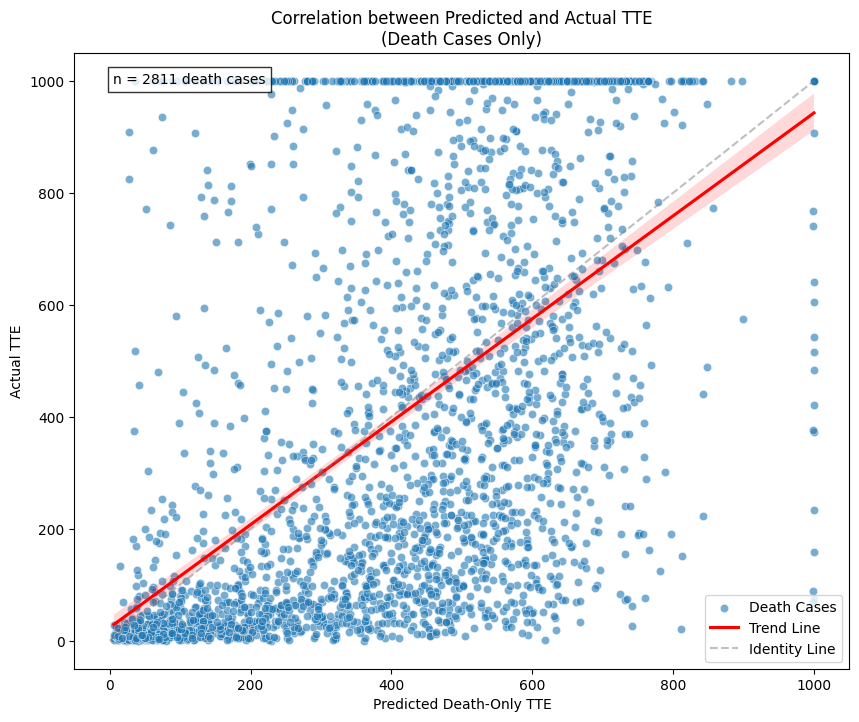


Summary statistics for death cases:

Predicted TTE:
count    2811.000000
mean      385.194193
std       227.985827
min         6.139824
25%       181.579345
50%       414.918661
75%       565.856310
max       999.748606
Name: predicted_death_only_tte, dtype: float64

Actual TTE:
count    2811.000000
mean      377.516542
std       369.223263
min         0.000000
25%        46.000000
50%       225.000000
75%       699.000000
max      1000.000000
Name: tte, dtype: float64


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Filter for death outcomes only
death_mask = real_df['outcome'] == 0
death_df = real_df[death_mask]

# Compute correlation coefficients for death cases only
pearson_corr, pearson_p = pearsonr(death_df['predicted_death_only_tte'], death_df['tte'])
spearman_corr, spearman_p = spearmanr(death_df['predicted_death_only_tte'], death_df['tte'])

print("Correlation statistics for death outcomes only:")
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3g})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3g})")

# Create a scatter plot with a regression line
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=death_df,
    x='predicted_death_only_tte',
    y='tte',
    alpha=0.6,
    label='Death Cases'
)
sns.regplot(
    data=death_df,
    x='predicted_death_only_tte',
    y='tte',
    scatter=False,
    color='red',
    label='Trend Line'
)

plt.xlabel('Predicted Death-Only TTE')
plt.ylabel('Actual TTE')
plt.title('Correlation between Predicted and Actual TTE\n(Death Cases Only)')
plt.legend()

# Add number of death cases to the plot
n_deaths = len(death_df)
plt.text(
    0.05, 0.95,
    f'n = {n_deaths} death cases',
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.8)
)

# Optional: Add identity line (y=x) for reference
min_val = min(death_df['predicted_death_only_tte'].min(), death_df['tte'].min())
max_val = max(death_df['predicted_death_only_tte'].max(), death_df['tte'].max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray', alpha=0.5, label='Identity Line')

plt.legend()
plt.show()

# Print additional statistics
print("\nSummary statistics for death cases:")
print("\nPredicted TTE:")
print(death_df['predicted_death_only_tte'].describe())
print("\nActual TTE:")
print(death_df['tte'].describe())

In [21]:
from sklearn.metrics import auc
from lifelines import CoxPHFitter
from scipy import stats
from sklearn.metrics import roc_auc_score


def calculate_cumulative_incidence(times, events, predict_time):
    """Calculate cumulative incidence at specified time"""
    n_total = len(times)
    n_events = sum((events == 1) & (times <= predict_time))
    return n_events / n_total

def bootstrap_ci(metric_func, data, n_bootstrap=1000, alpha=0.05):
    """Calculate confidence intervals using bootstrapping"""
    bootstrap_estimates = []
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, len(data), len(data))
        bootstrap_sample = data.iloc[indices]
        estimate = metric_func(bootstrap_sample)
        bootstrap_estimates.append(estimate)

    ci_lower = np.percentile(bootstrap_estimates, alpha/2 * 100)
    ci_upper = np.percentile(bootstrap_estimates, (1-alpha/2) * 100)
    return ci_lower, ci_upper

In [23]:
from sklearn.metrics import roc_auc_score

# Define time points for evaluation
time_points = [7, 14, 30, 90, 180, 360]
results = []

for t in time_points:
    # Create a mask to exclude transplants (assume outcome 2 is transplant)
    mask = real_df['outcome'].isin([0, 1])
    df_filtered = real_df[mask]

    # Create death indicator (1 if death occurred by time t, 0 if still waiting)
    death_indicator = ((df_filtered['outcome'] == 0) &
                       (df_filtered['tte'] <= t)).astype(int)

    # Define risk scores (the lower the predicted median time, the higher the risk)
    risk_scores = -df_filtered['predicted_death_only_tte']

    # Calculate AUC for death prediction using the filtered dataset
    death_auc = roc_auc_score(death_indicator, risk_scores)

    # Calculate cumulative incidence on the full dataset (if desired) or on df_filtered
    n_death = death_indicator.sum()
    # For cumulative incidence, you might want to consider only those in df_filtered as well:
    n_total = len(df_filtered)
    death_ci = n_death / n_total

    results.append({
        'Time': t,
        'N_death': n_death,
        'N_total': n_total,
        'Death_rate': death_ci,
        'AUC': death_auc
    })

results_df = pd.DataFrame(results)
print("\nResults at different time points (excluding transplants):")
print(results_df)



Results at different time points (excluding transplants):
   Time  N_death  N_total  Death_rate       AUC
0     7      210     4752    0.044192  0.873147
1    14      354     4752    0.074495  0.863711
2    30      575     4752    0.121002  0.834146
3    90      963     4752    0.202652  0.730136
4   180     1267     4752    0.266625  0.649334
5   360     1658     4752    0.348906  0.560722


In [26]:

from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Exclude transplants (outcome_encoded == 2)
df_filtered = real_df[real_df['outcome'].isin([0, 1])].copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - died on/before time t
    at_risk_mask = (
        (df_filtered['tte'] >= t) |
        ((df_filtered['outcome'] == 0) & (df_filtered['tte'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_filtered[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'] == 0) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    #    so we use the negative of that column.
    risk_metric = -df_at_risk['predicted_death_only_tte']

    #    For meld3, typically a higher meld3 => higher risk,
    #    so we can use it as is. (Adjust if your convention is reversed.)
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        # If we have all events or no events in this subset, AUC is not defined
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nNaive Time-Dependent AUC (Excluding Transplants):")
print(results_df)


Naive Time-Dependent AUC (Excluding Transplants):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7       4748            210    0.873246   0.952306
1    14       4740            354    0.864116   0.951342
2    30       4714            575    0.835274   0.943483
3    90       4647            963    0.733596   0.902831
4   180       4562           1267    0.657653   0.866671
5   360       4455           1658    0.574244   0.828922


In [28]:
from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients (both events and censored)
df_all = real_df.copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - had an event (death or transplant) on/before time t
    at_risk_mask = (
        (df_all['tte'] >= t) |
        ((df_all['outcome'].isin([0, 2])) & (df_all['tte'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death OR transplant occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    risk_metric = -df_at_risk['predicted_death_only_tte']
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nTime-Dependent AUC (Composite Outcome - Death or Transplant):")
print(results_df)


Time-Dependent AUC (Composite Outcome - Death or Transplant):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7      15910           3194    0.845878   0.882944
1    14      15902           4571    0.852777   0.883922
2    30      15876           6139    0.850455   0.880827
3    90      15809           8609    0.816230   0.855613
4   180      15724          10245    0.777516   0.838098
5   360      15617          11770    0.728982   0.824409


In [29]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_only_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_only_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_only_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_only_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.711          0.908             0.915
1    14           0.722          0.908             0.914
2    30           0.720          0.899             0.905
3    90           0.679          0.863             0.874
4   180           0.648          0.836             0.851
5   360           0.620          0.813             0.834

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      1.002     1.223     0.003      0.0
1    14      1.002     1.235     0.000      0.0
2    30      1.002     1.241     0.000      0.0
3    90      1.002     1.233     0.000      0.0
4   180      1.002     1.223     0.000      0.0
5   360      1.002     1.211     0.000      0.0


In [30]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# 1. Filter synthetic data to include both death and transplant events (outcomes 0 or 2)
composite_mask = syn_df_processed['outcome'].isin([0, 2])
composite_indices = syn_df_processed[composite_mask].index
composite_embeddings = syn_embeddings[composite_indices]

# 2. Set up nearest neighbor search using composite event embeddings
n_neighbors = 100
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(composite_embeddings)

# 3. Retrieve neighbor indices for all real patients
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# Configuration
ALPHA = 1e-6  # Small constant to avoid division by zero in weights

def compute_weighted_composite_tte(idx):
    """
    Compute a weighted average tte based on all neighbors (which are already filtered to death or transplant events).
    Weights are 1/(distance + ALPHA).

    Args:
        idx: Index of the real patient

    Returns:
        float: Weighted average time-to-event
        dict: Additional metrics including proportion of death vs transplant among neighbors
    """
    # Get neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Map back to original synthetic data indices
    original_neighbor_idxs = composite_indices[neighbor_idxs]

    # Get neighbor data
    neighbor_data = syn_df_processed.loc[original_neighbor_idxs]
    neighbor_ttes = neighbor_data['tte']

    # Compute inverse-distance weights
    weights = 1.0 / (neighbor_dists + ALPHA)

    # Calculate weighted average TTE
    weighted_tte = (weights * neighbor_ttes).sum() / weights.sum()

    # Calculate additional metrics
    metrics = {
        'n_death': (neighbor_data['outcome'] == 0).sum(),
        'n_transplant': (neighbor_data['outcome'] == 2).sum(),
        'death_proportion': (neighbor_data['outcome'] == 0).mean(),
        'transplant_proportion': (neighbor_data['outcome'] == 2).mean(),
    }

    return weighted_tte, metrics

# Number of real patients
n_real = indices_all.shape[0]

# Compute the weighted composite tte for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing weighted composite TTE", total=n_real)) as progress_bar:
    results = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )

# Unpack results
predicted_ttes, all_metrics = zip(*results)
predicted_composite_tte = np.array(predicted_ttes)

# Store the predictions and metrics in the real_df
real_df['predicted_composite_tte'] = predicted_composite_tte
real_df['n_death_neighbors'] = [m['n_death'] for m in all_metrics]
real_df['n_transplant_neighbors'] = [m['n_transplant'] for m in all_metrics]
real_df['death_neighbor_proportion'] = [m['death_proportion'] for m in all_metrics]
real_df['transplant_neighbor_proportion'] = [m['transplant_proportion'] for m in all_metrics]

# Display a sample of the predictions and metrics
print("\nSample of composite event predictions and metrics:")
print(real_df[[
    'predicted_composite_tte',
    'n_death_neighbors',
    'n_transplant_neighbors',
    'death_neighbor_proportion',
    'transplant_neighbor_proportion'
]].head())

# Print summary statistics
print("\nPrediction statistics:")
print(real_df['predicted_composite_tte'].describe())

print("\nNeighbor composition statistics:")
print("\nAverage proportion of death neighbors:")
print(real_df['death_neighbor_proportion'].mean())
print("\nAverage proportion of transplant neighbors:")
print(real_df['transplant_neighbor_proportion'].mean())


Computing weighted composite TTE:   0%|          | 0/15914 [00:00<?, ?it/s]

  0%|          | 0/15914 [00:00<?, ?it/s]

Computing weighted death-only TTE:   0%|          | 0/15914 [11:36<?, ?it/s]


Sample of composite event predictions and metrics:
   predicted_composite_tte  n_death_neighbors  n_transplant_neighbors  \
0               152.959340                100                       0   
1                34.975554                  0                     100   
2               655.167631                100                       0   
3               362.463109                100                       0   
4               185.693174                  0                     100   

   death_neighbor_proportion  transplant_neighbor_proportion  
0                        1.0                             0.0  
1                        0.0                             1.0  
2                        1.0                             0.0  
3                        1.0                             0.0  
4                        0.0                             1.0  

Prediction statistics:
count    15914.000000
mean       180.463797
std        177.503099
min          2.193104
25%         37.5080

In [31]:
from sklearn.metrics import roc_auc_score

# Define time points for evaluation
time_points = [7, 14, 30, 90, 180, 360]
results = []

for t in time_points:
    # Create a mask to exclude transplants (assume outcome 2 is transplant)
    mask = real_df['outcome'].isin([0, 1])
    df_filtered = real_df[mask]

    # Create death indicator (1 if death occurred by time t, 0 if still waiting)
    death_indicator = ((df_filtered['outcome'] == 0) &
                       (df_filtered['tte'] <= t)).astype(int)

    # Define risk scores (the lower the predicted median time, the higher the risk)
    risk_scores = -df_filtered['predicted_composite_tte']

    # Calculate AUC for death prediction using the filtered dataset
    death_auc = roc_auc_score(death_indicator, risk_scores)

    # Calculate cumulative incidence on the full dataset (if desired) or on df_filtered
    n_death = death_indicator.sum()
    # For cumulative incidence, you might want to consider only those in df_filtered as well:
    n_total = len(df_filtered)
    death_ci = n_death / n_total

    results.append({
        'Time': t,
        'N_death': n_death,
        'N_total': n_total,
        'Death_rate': death_ci,
        'AUC': death_auc
    })

results_df = pd.DataFrame(results)
print("\nResults at different time points (excluding transplants):")
print(results_df)



Results at different time points (excluding transplants):
   Time  N_death  N_total  Death_rate       AUC
0     7      210     4752    0.044192  0.873838
1    14      354     4752    0.074495  0.864163
2    30      575     4752    0.121002  0.835040
3    90      963     4752    0.202652  0.730669
4   180     1267     4752    0.266625  0.649711
5   360     1658     4752    0.348906  0.560974


In [32]:

from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Exclude transplants (outcome_encoded == 2)
df_filtered = real_df[real_df['outcome'].isin([0, 1])].copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - died on/before time t
    at_risk_mask = (
        (df_filtered['tte'] >= t) |
        ((df_filtered['outcome'] == 0) & (df_filtered['tte'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_filtered[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'] == 0) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    #    so we use the negative of that column.
    risk_metric = -df_at_risk['predicted_composite_tte']

    #    For meld3, typically a higher meld3 => higher risk,
    #    so we can use it as is. (Adjust if your convention is reversed.)
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        # If we have all events or no events in this subset, AUC is not defined
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nNaive Time-Dependent AUC (Excluding Transplants):")
print(results_df)


Naive Time-Dependent AUC (Excluding Transplants):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7       4748            210    0.873936   0.952306
1    14       4740            354    0.864567   0.951342
2    30       4714            575    0.836165   0.943483
3    90       4647            963    0.734125   0.902831
4   180       4562           1267    0.658022   0.866671
5   360       4455           1658    0.574436   0.828922


In [33]:
from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients (both events and censored)
df_all = real_df.copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - had an event (death or transplant) on/before time t
    at_risk_mask = (
        (df_all['tte'] >= t) |
        ((df_all['outcome'].isin([0, 2])) & (df_all['tte'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death OR transplant occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    risk_metric = -df_at_risk['predicted_composite_tte']
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nTime-Dependent AUC (Composite Outcome - Death or Transplant):")
print(results_df)


Time-Dependent AUC (Composite Outcome - Death or Transplant):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7      15910           3194    0.874738   0.882944
1    14      15902           4571    0.877172   0.883922
2    30      15876           6139    0.871261   0.880827
3    90      15809           8609    0.838176   0.855613
4   180      15724          10245    0.810691   0.838098
5   360      15617          11770    0.780336   0.824409


In [34]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.716          0.908             0.926
1    14           0.721          0.908             0.929
2    30           0.703          0.899             0.926
3    90           0.626          0.863             0.911
4   180           0.578          0.836             0.901
5   360           0.459          0.813             0.891

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      1.004     1.245       0.0      0.0
1    14      1.004     1.260       0.0      0.0
2    30      1.004     1.272       0.0      0.0
3    90      1.005     1.274       0.0      0.0
4   180      1.005     1.269       0.0      0.0
5   360      1.005     1.257       0.0      0.0


In [43]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 50       # Use the 100 closest neighbors
ALPHA = 1e-6      # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    For each outcome group (0: death, 1: waiting, 2: transplant):
      - Compute a weighted average tte using inverse-distance weighting.
      - Compute the proportion of neighbors in that group.
    The final predicted tte is the sum of each group's (weighted average tte × proportion).

    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient.
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors.
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over each outcome group: 0, 1, 2.
    for outcome in [0, 1, 2]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group.
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights.
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute.
            composite_tte += 0.0
    return composite_tte

# Number of real patients (assumed available from indices_all)
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel.
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df under a new column.
real_df['predicted_composite_tte'] = predicted_tte

# Optional: display a sample of the predictions.
print(real_df[['predicted_composite_tte']].head())


Computing composite weighted TTE:   0%|          | 0/15914 [00:00<?, ?it/s]

  0%|          | 0/15914 [00:00<?, ?it/s]

   predicted_composite_tte
0               112.964033
1               114.158698
2               127.515632
3               156.117464
4               126.406779


In [44]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.512          0.908             0.908
1    14           0.516          0.908             0.908
2    30           0.521          0.899             0.899
3    90           0.513          0.863             0.863
4   180           0.513          0.836             0.837
5   360           0.514          0.813             0.814

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.999     1.200     0.782      0.0
1    14      1.000     1.211     0.899      0.0
2    30      1.001     1.218     0.710      0.0
3    90      1.000     1.201     0.751      0.0
4   180      1.000     1.184     0.699      0.0
5   360      1.001     1.164     0.101      0.0


In [39]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 20       # Use the 20 closest death neighbors
ALPHA = 1e-6     # Small constant to avoid division by zero

def compute_weighted_death_tte(idx):
    """
    Compute a weighted average tte based on the TOP_K nearest neighbors who died (outcome 0).
    Uses inverse-distance weighting.

    If no neighbors died, returns None to flag this case.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Filter for death outcomes only
    death_neighbors = neighbors[neighbors['outcome'] == 0]

    if len(death_neighbors) > 0:
        # Use only the TOP_K closest death neighbors
        death_neighbors = death_neighbors.sort_values('dist').head(TOP_K)

        # Compute inverse-distance weights
        weights = 1.0 / (death_neighbors['dist'] + ALPHA)

        # Calculate weighted average TTE
        weighted_tte = (weights * death_neighbors['tte']).sum() / weights.sum()

        # Return prediction and number of death neighbors used
        return {
            'predicted_tte': weighted_tte,
            'n_death_neighbors': len(death_neighbors),
            'mean_neighbor_dist': death_neighbors['dist'].mean(),
            'min_neighbor_dist': death_neighbors['dist'].min(),
            'max_neighbor_dist': death_neighbors['dist'].max()
        }
    else:
        # No death neighbors found
        return {
            'predicted_tte': None,
            'n_death_neighbors': 0,
            'mean_neighbor_dist': None,
            'min_neighbor_dist': None,
            'max_neighbor_dist': None
        }

# Number of real patients
n_real = indices_all.shape[0]

# Compute predictions for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing death-only weighted TTE", total=n_real)) as progress_bar:
    predictions = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_death_tte)(i) for i in range(n_real)
    )

# Convert predictions to DataFrame columns
real_df['predicted_death_tte'] = [p['predicted_tte'] for p in predictions]
real_df['n_death_neighbors'] = [p['n_death_neighbors'] for p in predictions]
real_df['mean_neighbor_dist'] = [p['mean_neighbor_dist'] for p in predictions]
real_df['min_neighbor_dist'] = [p['min_neighbor_dist'] for p in predictions]
real_df['max_neighbor_dist'] = [p['max_neighbor_dist'] for p in predictions]

# Print summary statistics
print("\nPrediction Summary:")
print(f"Total patients: {n_real}")
print(f"Patients with valid predictions: {real_df['predicted_death_tte'].notna().sum()}")
print("\nNeighbor Statistics:")
print(real_df[['n_death_neighbors', 'mean_neighbor_dist']].describe())

# Display sample predictions
print("\nSample predictions:")
print(real_df[[
    'predicted_death_tte',
    'n_death_neighbors',
    'mean_neighbor_dist',
    'min_neighbor_dist',
    'max_neighbor_dist'
]].head())

Computing death-only weighted TTE:   0%|          | 0/15914 [00:00<?, ?it/s]

  0%|          | 0/15914 [00:00<?, ?it/s]


Prediction Summary:
Total patients: 15914
Patients with valid predictions: 15914

Neighbor Statistics:
       n_death_neighbors  mean_neighbor_dist
count       15914.000000        15914.000000
mean           18.418185            0.066017
std             2.266203            0.057912
min             6.000000            0.000060
25%            17.000000            0.013325
50%            20.000000            0.060626
75%            20.000000            0.094376
max            20.000000            0.466494

Sample predictions:
   predicted_death_tte  n_death_neighbors  mean_neighbor_dist  \
0           305.753996                 20            0.151025   
1           476.329745                 14            0.006819   
2           486.798378                 16            0.061433   
3           333.291804                 19            0.058376   
4           384.733696                 17            0.086786   

   min_neighbor_dist  max_neighbor_dist  
0           0.132241           0.1653

In [40]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.500          0.908             0.908
1    14           0.506          0.908             0.908
2    30           0.506          0.899             0.899
3    90           0.503          0.863             0.863
4   180           0.500          0.836             0.836
5   360           0.501          0.813             0.813

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7        1.0     1.200     0.854      0.0
1    14        1.0     1.211     0.550      0.0
2    30        1.0     1.218     0.428      0.0
3    90        1.0     1.201     0.542      0.0
4   180        1.0     1.184     0.642      0.0
5   360        1.0     1.164     0.330      0.0


In [41]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 20       # Use the 20 closest neighbors
ALPHA = 1e-6     # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a weighted average tte based on the TOP_K nearest neighbors who either
    died (outcome 0) or received transplant (outcome 2).
    Uses inverse-distance weighting.

    If no neighbors had either outcome, returns None to flag this case.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Filter for death or transplant outcomes
    event_neighbors = neighbors[neighbors['outcome'].isin([0, 2])]

    if len(event_neighbors) > 0:
        # Use only the TOP_K closest event neighbors
        event_neighbors = event_neighbors.sort_values('dist').head(TOP_K)

        # Compute inverse-distance weights
        weights = 1.0 / (event_neighbors['dist'] + ALPHA)

        # Calculate weighted average TTE
        weighted_tte = (weights * event_neighbors['tte']).sum() / weights.sum()

        # Count neighbors by outcome
        n_death = (event_neighbors['outcome'] == 0).sum()
        n_transplant = (event_neighbors['outcome'] == 2).sum()

        return {
            'predicted_tte': weighted_tte,
            'n_death_neighbors': n_death,
            'n_transplant_neighbors': n_transplant,
            'total_event_neighbors': len(event_neighbors),
            'mean_neighbor_dist': event_neighbors['dist'].mean(),
            'min_neighbor_dist': event_neighbors['dist'].min(),
            'max_neighbor_dist': event_neighbors['dist'].max(),
            'death_proportion': n_death / len(event_neighbors),
            'transplant_proportion': n_transplant / len(event_neighbors)
        }
    else:
        # No qualifying neighbors found
        return {
            'predicted_tte': None,
            'n_death_neighbors': 0,
            'n_transplant_neighbors': 0,
            'total_event_neighbors': 0,
            'mean_neighbor_dist': None,
            'min_neighbor_dist': None,
            'max_neighbor_dist': None,
            'death_proportion': None,
            'transplant_proportion': None
        }

# Number of real patients
n_real = indices_all.shape[0]

# Compute predictions for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predictions = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )

# Convert predictions to DataFrame columns
real_df['predicted_composite_tte'] = [p['predicted_tte'] for p in predictions]
real_df['n_death_neighbors'] = [p['n_death_neighbors'] for p in predictions]
real_df['n_transplant_neighbors'] = [p['n_transplant_neighbors'] for p in predictions]
real_df['total_event_neighbors'] = [p['total_event_neighbors'] for p in predictions]
real_df['mean_neighbor_dist'] = [p['mean_neighbor_dist'] for p in predictions]
real_df['min_neighbor_dist'] = [p['min_neighbor_dist'] for p in predictions]
real_df['max_neighbor_dist'] = [p['max_neighbor_dist'] for p in predictions]
real_df['death_proportion'] = [p['death_proportion'] for p in predictions]
real_df['transplant_proportion'] = [p['transplant_proportion'] for p in predictions]

# Print summary statistics
print("\nPrediction Summary:")
print(f"Total patients: {n_real}")
print(f"Patients with valid predictions: {real_df['predicted_composite_tte'].notna().sum()}")

print("\nNeighbor Composition:")
print("Average proportions across all predictions:")
print(f"Death: {real_df['death_proportion'].mean():.3f}")
print(f"Transplant: {real_df['transplant_proportion'].mean():.3f}")

print("\nNeighbor Statistics:")
print(real_df[[
    'n_death_neighbors',
    'n_transplant_neighbors',
    'mean_neighbor_dist'
]].describe())

# Display sample predictions
print("\nSample predictions:")
print(real_df[[
    'predicted_composite_tte',
    'n_death_neighbors',
    'n_transplant_neighbors',
    'death_proportion',
    'transplant_proportion',
    'mean_neighbor_dist'
]].head())


Computing composite weighted TTE:   0%|          | 0/15914 [00:00<?, ?it/s]

  0%|          | 0/15914 [00:00<?, ?it/s]

Computing death-only weighted TTE:   0%|          | 0/15914 [05:21<?, ?it/s]



Prediction Summary:
Total patients: 15914
Patients with valid predictions: 15914

Neighbor Composition:
Average proportions across all predictions:
Death: 0.201
Transplant: 0.799

Neighbor Statistics:
       n_death_neighbors  n_transplant_neighbors  mean_neighbor_dist
count       15914.000000            15914.000000        15914.000000
mean            4.022936               15.977064            0.049951
std             1.792382                1.792382            0.050248
min             0.000000                7.000000            0.000031
25%             3.000000               15.000000            0.010127
50%             4.000000               16.000000            0.040889
75%             5.000000               17.000000            0.067520
max            13.000000               20.000000            0.448756

Sample predictions:
   predicted_composite_tte  n_death_neighbors  n_transplant_neighbors  \
0               259.923790                  5                      15   
1         